In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

## Reflecting Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# added inspect when trying somehting, will see if need 

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Declaring a Base using `automap_base()` to reflect the existing database into a new model
Base = automap_base()

# Using the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [7]:
# Printing all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Saving references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create the session to link Python to the DB
session = Session(engine)

In [10]:
# Obtaining column names and data types for measurement class 
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Obtaining column names and data types for station class
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Exploratory Climate Analysis

In [12]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results


In [13]:
# Finding the last data point in the data base
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_data_point[0]

'2017-08-23'

In [14]:
#year_ago = dt.date(int(last_data_point[0])) - dt.timedelta(days=365)

In [15]:
last_date = dt.datetime.strptime(last_data_point[0], "%Y-%m-%d")
last_date

datetime.datetime(2017, 8, 23, 0, 0)

In [16]:
# Calculating the date 1 year from the last data point in the database
year_ago = dt.date(last_date.year, last_date.month, last_date.day) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [17]:
# Calculating the date 1 year from the last data point in the database
#year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#year_ago

In [18]:
# Performing a query to retrieve the data and precipitation scores
# Ordering the data from the earliest date to the latest date
query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

In [19]:
# Saving the query results as a Pandas DataFrame and setting the index to the date column
df = pd.DataFrame(query, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df.head(10)


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


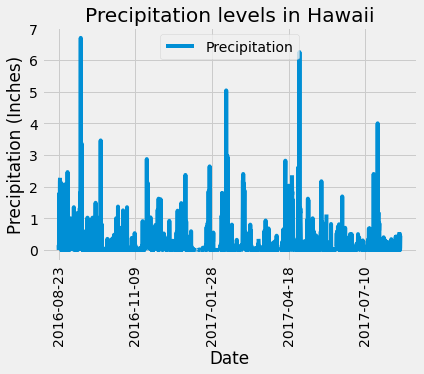

In [20]:
# Plotting the data as a bar plot over time
df.plot(rot=90)
plt.title("Precipitation levels in Hawaii")
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.legend(['Precipitation'])
plt.show()

# see if can move legend

In [21]:
# Using Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Designing a query to show how many stations are available in this dataset
stations = session.query(Station.station).count()

stations

9

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# this would be looking at the number of times each station id is in the measurements table
# so how many rows have the station id in the station column

# using a group by?? group by the station id and do count as the aggregation, then do an order by and desc

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

active_stations

# this lists the station ids and the number of times they appear


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
type(active_stations)

list

In [25]:
# Outlining the most active station from the list above

most_active_station = active_stations[0][0]

name_most_active_station = session.query(Station.name).filter(Station.station == most_active_station).first()

print(f"The most active station is {name_most_active_station[0]}, with ID number {most_active_station}.")

The most active station is WAIHEE 837.5, HI US, with ID number USC00519281.


In [26]:
most_active_station = active_stations[0][0]

In [27]:
name_most_active_station = (session.query(Station.name).filter(Station.station == most_active_station).first())[0]
name_most_active_station

'WAIHEE 837.5, HI US'

In [28]:
print(f"The most active station is {name_most_active_station}, with ID number {most_active_station}.")

The most active station is WAIHEE 837.5, HI US, with ID number USC00519281.


In [29]:
# Calculating the lowest temperature recorded, the highest temperature recorded, and average temperature of the most active station

# Maximum temperature
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).first()

print(f"The maximum temperature recorded in {name_most_active_station[0]} is {max_temp[0]} degrees Fahrenheit.")

# Minimum temperature
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).first()

print(f"The minimum temperature recorded in {name_most_active_station[0]} is {min_temp[0]} degrees Fahrenheit.")

avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).first()

print(f"The average temperature recorded in {name_most_active_station[0]} is {round(avg_temp[0],2)} degrees Fahrenheit.")


# i think what I want printed int he list at the end I put in session.query(). so in the brackets
# if I want the whole thing, some columns, a particular column etc. (or i guuess element in list thing because not table)
# so only care about temperature thing really 

The maximum temperature recorded in W is 85.0 degrees Fahrenheit.
The minimum temperature recorded in W is 54.0 degrees Fahrenheit.
The average temperature recorded in W is 71.66 degrees Fahrenheit.


In [30]:
# Quering the last 12 months of temperature observation data for this station and plotting the results as a histogram

year_of_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.date).all()

#year_of_temps

#I dont get it wouldn't this just be the most active station?? so the same as the one we were doing above??
# or are they saying there are some that don't have the temperature observaation written down?? and maybe just prcp 
# recorded??? I don't get it 

In [31]:
df_temps = pd.DataFrame(year_of_temps, columns=['Date', 'Temperature'])
df_temps.set_index('Date', inplace=True)
df_temps.head(10)

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
2016-08-29,78.0
2016-08-30,77.0
2016-08-31,78.0


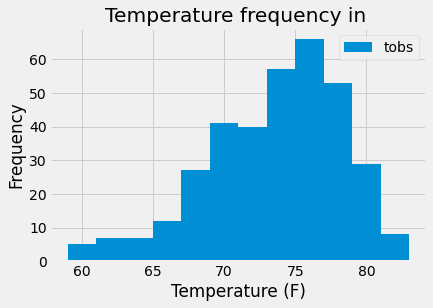

In [32]:
# Plotting the histogram

df_temps.plot.hist(bins = 12)
plt.title("Temperature frequency in ")
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

## Bonus: Temperature Analysis I

In [33]:
# Identify the average temperature in June at all stations across all available years in the dataset. 

june = "06"

avg_june = session.query(func.avg(Measurement.tobs)).\
            filter(func.strftime("%m", Measurement.date) == june).first()

print(f"The average temperature recorded across all stations in June is {round(avg_june[0],2)} degrees Fahrenheit.")
#session.query(Dow.date).\filter(func.strftime("%d", Dow.date) == date_str).all()

#Do the same for December temperature.
december = "12"

avg_december = session.query(func.avg(Measurement.tobs)).\
            filter(func.strftime("%m", Measurement.date) == december).first()

print(f"The average temperature recorded across all stations in December is {round(avg_december[0],2)} degrees Fahrenheit.")


The average temperature recorded across all stations in June is 74.94 degrees Fahrenheit.
The average temperature recorded across all stations in December is 71.04 degrees Fahrenheit.


In [34]:
june_temps = session.query(Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == june).all()

june_list = []
for x in june_temps:
        june_list.append(x.tobs)

december_temps = session.query(Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == december).all()


december_list = []
for x in december_temps:
        december_list.append(x.tobs)
        


In [35]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Will you use a paired t-test, or an unpaired t-test? Why?

# unpaired????
# b/c Compares the means of different groups
# different months means different groups?????
# b/c I feel like same group would be same month on different years in this context


from scipy import stats

# Unpaired (independent) t-test
stats.ttest_ind(june_list, december_list)
# think needs whole list of data for this

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

## Bonus: Temperature Analysis II

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [40]:
# Will be planning a trip for 2021-04-01 to 2021-04-15. The most recently available data is in 2017
# Therefore using 2017 dates to obtain an idea of the temp during my trip:
start_date = '2017-04-01'
end_date = '2017-04-15'

# Using function `calc_temps` to calculate the tmin, tavg, and tmax for the trip using the previously available data 

trip_temp = calc_temps(start_date, end_date)
trip_temp

[(67.0, 74.47368421052632, 82.0)]

In [42]:
trip_temp[0][0]

67.0

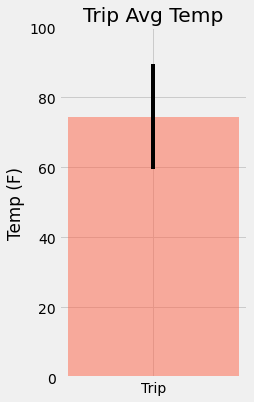

In [71]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

y_value = trip_temp[0][1]
yerr = trip_temp[0][2] - trip_temp[0][0]

plt.figure(figsize=(3,6))
plt.bar("Trip", y_value, width = 0.1, yerr = yerr, color = "tomato", alpha = 0.5)
plt.ylim(0,100)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
#plt.tight_layout
plt.show()

In [72]:
# Calculating total rainfall amount per weather station for the trip dates using the available year's matching dates.

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-04-01'
end_date = '2017-04-15'

sel = [Station.station, Station.name, func.sum(Measurement.prcp).label("Total prcp"), Station.latitude, Station.longitude, Station.elevation]

total_rainfall = session.query(*sel).filter(Station.station == Measurement.station).\
                    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                    group_by(Station.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()

total_rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  5.75,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  4.14,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 1.64, 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.8999999999999999,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.36,
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.27, 21.2716, -157.8168, 3.0),
 ('USC00517948', 'PEARL CITY, HI US', 0.0, 21.3934, -157.9751, 11.9)]

In [76]:
#convert query object to data frame
total_rainfall_df = pd.DataFrame(np.array(total_rainfall))


total_rainfall_df = total_rainfall_df.rename(columns={0: "Station ID", 1: "Station Name", 2: "Total Precipitation", 
                                                      3: "Latitude", 4: "Longitude", 5: "Elevation"})
total_rainfall_df

total_rainfall_df.set_index("Station ID")

# decide whether to have station id as index??
# I'm not sure why there are only 7 stations when there are 9 in the data set??
# do the other twojust not have data for my dates????

,Station Name,Total Precipitation,Latitude,Longitude,Elevation
Station ID,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",5.75,21.3331,-157.8025,152.4
USC00519281,"WAIHEE 837.5, HI US",4.14,21.45167,-157.84888999999998,32.9
USC00513117,"KANEOHE 838.1, HI US",1.64,21.4234,-157.8015,14.6
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.8999999999999999,21.5213,-157.8374,7.0
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.36,21.33556,-157.71139,19.5
USC00519397,"WAIKIKI 717.2, HI US",0.27,21.2716,-157.8168,3.0
USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


## Bonus: Daily Rainfall Average

In [164]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [165]:
# so does the daily normals for the entered date across each year

In [166]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = '2017-04-01'
trip_end_date = '2017-04-15'

start_date = dt.datetime.strptime(trip_start_date, "%Y-%m-%d")

end_date = dt.datetime.strptime(trip_end_date, "%Y-%m-%d")

length_of_trip = end_date.day - start_date.day
length_of_trip


    # Finding the date a year from the last point in the data set
    #year_ago = dt.date(last_date.year, last_date.month, last_date.day) - dt.timedelta(days=365)

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

14

In [167]:
start_date

datetime.datetime(2017, 4, 1, 0, 0)

In [168]:
day = start_date.day -1
day

0

In [169]:
type(day)

int

In [170]:
date_list = []
day_date = start_date.day -1
month = start_date.month
month_string = str(month)

for x in range(0, length_of_trip):
    day_date = day_date + 1
    #day_string = str(day_date)
    
    if x < 9:
        month_day_date = f"0{month}-0{day_date}"
    
    else:
        month_day_date = f"0{month}-{day_date}"
    
        
    
    date_list.append(month_day_date)
    


In [171]:
date_list

['04-01',
 '04-02',
 '04-03',
 '04-04',
 '04-05',
 '04-06',
 '04-07',
 '04-08',
 '04-09',
 '04-10',
 '04-11',
 '04-12',
 '04-13',
 '04-14']

In [172]:
len(date_list)

14

In [173]:
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [174]:
normals = []

for n in range(len(date_list)):
    
    #date = date_list[n]
    
    #normal = daily_normals(f"{date}")
    
    normal = daily_normals(date_list[n])
    
    #print(date)
    normals.append(normal[0])
    
    



In [175]:
normals

[(60.0, 71.87931034482759, 80.0),
 (53.0, 71.82142857142857, 79.0),
 (55.0, 72.2280701754386, 78.0),
 (58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142857, 77.0),
 (63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0)]

In [176]:
type(normals)

list

In [177]:
total_rainfall_df = pd.DataFrame(np.array(total_rainfall))


total_rainfall_df = total_rainfall_df.rename(columns={0: "Station ID", 1: "Station Name", 2: "Total Precipitation", 
                                                      3: "Latitude", 4: "Longitude", 5: "Elevation"})
total_rainfall_df

,Station ID,Station Name,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",5.75,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",4.14,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",1.64,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.8999999999999999,21.5213,-157.8374,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.36,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.27,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


In [178]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(np.array(normals))

normal_df = normal_df.rename(columns = {0: "Daily Normals: tmin", 1: "Daily Normals: tavg", 2: "Daily Normals: tmax" })
normal_df

,Daily Normals: tmin,Daily Normals: tavg,Daily Normals: tmax
0,60.0,71.879310,80.0
1,53.0,71.821429,79.0
2,55.0,72.228070,78.0
3,58.0,72.016393,78.0
4,61.0,72.288136,80.0
5,67.0,71.571429,77.0
6,63.0,71.105263,78.0
7,66.0,72.105263,77.0
8,62.0,71.614035,78.0
9,64.0,71.403509,79.0


In [179]:
normal_df["Date"] = date_list
normal_df

,Daily Normals: tmin,Daily Normals: tavg,Daily Normals: tmax,Date
0,60.0,71.879310,80.0,04-01
1,53.0,71.821429,79.0,04-02
2,55.0,72.228070,78.0,04-03
3,58.0,72.016393,78.0,04-04
4,61.0,72.288136,80.0,04-05
5,67.0,71.571429,77.0,04-06
6,63.0,71.105263,78.0,04-07
7,66.0,72.105263,77.0,04-08
8,62.0,71.614035,78.0,04-09
9,64.0,71.403509,79.0,04-10


In [180]:
normal_df = normal_df.set_index("Date")

normal_df

,Daily Normals: tmin,Daily Normals: tavg,Daily Normals: tmax
Date,,,
04-01,60.0,71.879310,80.0
04-02,53.0,71.821429,79.0
04-03,55.0,72.228070,78.0
04-04,58.0,72.016393,78.0
04-05,61.0,72.288136,80.0
04-06,67.0,71.571429,77.0
04-07,63.0,71.105263,78.0
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0


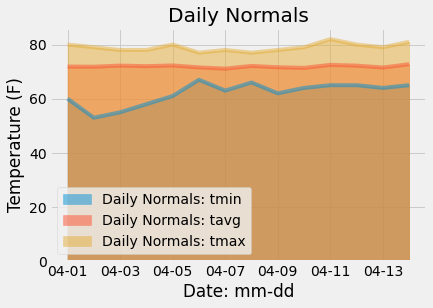

In [187]:
# Plot the daily normals as an area plot with `stacked=False`

normal_df.plot.area(stacked=False)
plt.title("Daily Normals")
plt.ylabel("Temperature (F)")
plt.xlabel("Date: mm-dd")
plt.show()